# 1. ÌïÑÏöîÎ™®Îìà Î∂àÎü¨Ïò§Í∏∞

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from autogluon.multimodal import MultiModalPredictor

# import ace_tools_open as tools
# from sklearn.model_selection import KFold, RandomizedSearchCV
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from urllib.parse import urlparse, parse_qs
# import tldextract
# import re
# import base64
# import seaborn as sns
# import matplotlib.pyplot as plt
# from collections import Counter
# from Levenshtein import distance as levenshtein_distance

import warnings
warnings.filterwarnings(action='ignore')

2025-02-21 18:27:58.757852: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 18:27:58.759090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 18:27:58.779204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-21 18:27:59.141938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 2. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [3]:
# ÌïôÏäµ/ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞ Î°úÎìú
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# '[.]'ÏùÑ '.'ÏúºÎ°ú Î≥µÍµ¨
train_df['URL'] = train_df['URL'].apply(lambda x: x.replace('[.]', '.'))
test_df['URL'] = test_df['URL'].apply(lambda x: x.replace('[.]', '.'))

# 3. Feature Engineering

In [11]:
## ÏÉàÎ°úÏö¥ Î≥ÄÏàò ÏÉùÏÑ±
# URL Í∏∏Ïù¥
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

# ÏÑúÎ∏åÎèÑÎ©îÏù∏ Í∞úÏàò
train_df['subdomain_count'] = train_df['URL'].str.split('.').apply(lambda x: len(x) - 2)
test_df['subdomain_count'] = test_df['URL'].str.split('.').apply(lambda x: len(x) - 2)

# ÌäπÏàò Î¨∏Ïûê('-', '_', '/') Í∞úÏàò
train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))

In [12]:
def extract_query_features(url):
    parsed_url = urlparse(url)
    query_params = parse_qs(parsed_url.query)
    
    # ÏøºÎ¶¨ ÌååÎùºÎØ∏ÌÑ∞ Í∞úÏàò
    num_query_params = len(query_params)
    
    # ÏùòÏã¨ ÌÇ§ÏõåÎìú Ìè¨Ìï® Ïó¨Î∂Ä (Ïòà: id, token, password, auth Îì±)
    suspicious_query_keys = {'id', 'token', 'password', 'auth', 'key', 'login'}
    contains_suspicious_query = any(key in suspicious_query_keys for key in query_params.keys())
    
    # ÏøºÎ¶¨ Í∞íÏùò ÌèâÍ∑† Í∏∏Ïù¥
    query_lengths = [len(value[0]) for value in query_params.values() if value]  # Í∞íÏù¥ Ï°¥Ïû¨ÌïòÎäî Í≤ΩÏö∞Îßå
    avg_query_length = sum(query_lengths) / len(query_lengths) if query_lengths else 0
    
    return pd.Series([num_query_params, contains_suspicious_query, avg_query_length], 
                     index=['num_query_params', 'contains_suspicious_query', 'avg_query_length'])

def extract_path_features(url):
    # URLÏóêÏÑú Í≤ΩÎ°ú Ï∂îÏ∂ú
    path = url.split('//')[-1].split('/', 1)[-1] if '/' in url else ''
    
    # Í≤ΩÎ°ú Í∏∏Ïù¥
    path_length = len(path)
    
    # ÏùòÏã¨ ÌÇ§ÏõåÎìú Ìè¨Ìï® Ïó¨Î∂Ä (Ïòà: admin, wp-login, bank, free Îì±)
    suspicious_keywords = {'admin', 'wp-login', 'paypal', 'bank', 'free', 'secure'}
    contains_suspicious_keyword = any(keyword in path.lower() for keyword in suspicious_keywords)
    
    # ÏúÑÌóòÌïú ÌååÏùº ÌôïÏû•Ïûê Ìè¨Ìï® Ïó¨Î∂Ä
    dangerous_extensions = {'.exe', '.php', '.zip', '.rar', '.apk'}
    contains_dangerous_extension = any(path.lower().endswith(ext) for ext in dangerous_extensions)
    
    return pd.Series([path_length, contains_suspicious_keyword, contains_dangerous_extension], 
                     index=['path_length', 'contains_suspicious_keyword', 'contains_dangerous_extension'])

# Shannon Entropy Í≥ÑÏÇ∞ Ìï®Ïàò
def shannon_entropy(string):
    prob = [freq / len(string) for freq in Counter(string).values()]
    return -sum(p * np.log2(p) for p in prob)

# Ïú†Î™Ö ÎèÑÎ©îÏù∏ Î¶¨Ïä§Ìä∏ (Í≥µÏãù ÎèÑÎ©îÏù∏Í≥º Ïú†ÏÇ¨ÏÑ± Ï≤¥ÌÅ¨)
popular_domains = ['google.com', 'facebook.com', 'amazon.com', 'paypal.com', 'microsoft.com']

def extract_advanced_domain_features(url):
    ext = tldextract.extract(url)
    domain = ext.domain

    # ÎèÑÎ©îÏù∏ Î¨∏ÏûêÏó¥Ïùò Shannon Entropy (Î¨∏Ïûê Îã§ÏñëÏÑ±)
    entropy = shannon_entropy(domain) if domain else 0

    # ÎèÑÎ©îÏù∏Ïóê Ìè¨Ìï®Îêú Ïà´Ïûê Í∞úÏàò
    num_digits = sum(c.isdigit() for c in domain)

    # Ïú†Î™Ö ÎèÑÎ©îÏù∏Í≥ºÏùò ÏµúÏÜå Levenshtein Í±∞Î¶¨ (Ï≤†Ïûê Ïú†ÏÇ¨ÎèÑ)
    min_levenshtein_dist = min(levenshtein_distance(domain, pop_dom.split('.')[0]) for pop_dom in popular_domains)

    return pd.Series([entropy, num_digits, min_levenshtein_dist], 
                     index=['domain_entropy', 'num_digits_in_domain', 'min_levenshtein_dist'])

def extract_advanced_path_features(url):
    path = url.split('//')[-1].split('/', 1)[-1] if '/' in url else ''
    
    # URL Í≤ΩÎ°ú ÎÇ¥ ÎåÄÎ¨∏Ïûê ÎπÑÏú®
    upper_case_ratio = sum(1 for c in path if c.isupper()) / len(path) if path else 0

    # Ïó∞ÏÜçÎêú ÎèôÏùº Î¨∏Ïûê ÏµúÎåÄ Í∞úÏàò (Ïòà: "aaaaa123")
    max_repeated_char = max((len(list(g)) for _, g in re.findall(r"(.)\1*", path)), default=1)

    # URL ÎÇ¥ Î∞±Ïä¨ÎûòÏãú Ìè¨Ìï® Ïó¨Î∂Ä
    contains_backslash = 1 if '\\' in url else 0

    return pd.Series([upper_case_ratio, max_repeated_char, contains_backslash], 
                     index=['upper_case_ratio', 'max_repeated_char', 'contains_backslash'])

def is_base64(s):
    """Base64 Ïó¨Î∂Ä ÌôïÏù∏"""
    try:
        decoded = base64.b64decode(s, validate=True)
        return True
    except Exception:
        return False

def extract_advanced_query_features(url):
    parsed_url = urlparse(url)
    query_params = parse_qs(parsed_url.query)
    
    # ÏøºÎ¶¨ ÌÇ§ ÌèâÍ∑† Í∏∏Ïù¥
    avg_query_key_length = np.mean([len(key) for key in query_params.keys()]) if query_params else 0

    # Base64 Ïù∏ÏΩîÎî©Îêú Í∞í Ìè¨Ìï® Ïó¨Î∂Ä
    contains_base64 = any(is_base64(value[0]) for value in query_params.values() if value)

    # ÎèôÏùºÌïú ÌÇ§Í∞Ä Ïó¨Îü¨ Î≤à Îì±Ïû•ÌïòÎäî Í≤ΩÏö∞
    repeated_query_keys = len(query_params) != len(set(query_params.keys()))

    return pd.Series([avg_query_key_length, contains_base64, repeated_query_keys], 
                     index=['avg_query_key_length', 'contains_base64', 'repeated_query_keys'])

In [13]:
train_df[['domain_entropy', 'num_digits_in_domain', 'min_levenshtein_dist']] = train_df['URL'].apply(extract_advanced_domain_features)
tools.display_dataframe_to_user(name="ÎèÑÎ©îÏù∏ Î¨∏Ïûê Îã§ÏñëÏÑ± Î∞è Ïú†ÏÇ¨ÏÑ± ÌîºÏ≤ò", dataframe=train_df)

# train_df[['upper_case_ratio', 'max_repeated_char', 'contains_backslash']] = train_df['URL'].apply(extract_advanced_path_features)
# tools.display_dataframe_to_user(name="URL Í≤ΩÎ°ú ÎÇ¥ Î¨∏Ïûê ÌäπÏÑ± ÌîºÏ≤ò", dataframe=train_df)

train_df[['avg_query_key_length', 'contains_base64', 'repeated_query_keys']] = train_df['URL'].apply(extract_advanced_query_features)
tools.display_dataframe_to_user(name="ÏøºÎ¶¨ ÌååÎùºÎØ∏ÌÑ∞ ÌäπÏÑ± ÌîºÏ≤ò", dataframe=train_df)

ÎèÑÎ©îÏù∏ Î¨∏Ïûê Îã§ÏñëÏÑ± Î∞è Ïú†ÏÇ¨ÏÑ± ÌîºÏ≤ò


ÏøºÎ¶¨ ÌååÎùºÎØ∏ÌÑ∞ ÌäπÏÑ± ÌîºÏ≤ò


In [14]:
test_df[['domain_entropy', 'num_digits_in_domain', 'min_levenshtein_dist']] = test_df['URL'].apply(extract_advanced_domain_features)
tools.display_dataframe_to_user(name="ÎèÑÎ©îÏù∏ Î¨∏Ïûê Îã§ÏñëÏÑ± Î∞è Ïú†ÏÇ¨ÏÑ± ÌîºÏ≤ò", dataframe=test_df)

# test_df[['upper_case_ratio', 'max_repeated_char', 'contains_backslash']] = test_df['URL'].apply(extract_advanced_path_features)
# tools.display_dataframe_to_user(name="URL Í≤ΩÎ°ú ÎÇ¥ Î¨∏Ïûê ÌäπÏÑ± ÌîºÏ≤ò", dataframe=test_df)

test_df[['avg_query_key_length', 'contains_base64', 'repeated_query_keys']] = test_df['URL'].apply(extract_advanced_query_features)
tools.display_dataframe_to_user(name="ÏøºÎ¶¨ ÌååÎùºÎØ∏ÌÑ∞ ÌäπÏÑ± ÌîºÏ≤ò", dataframe=test_df)

ÎèÑÎ©îÏù∏ Î¨∏Ïûê Îã§ÏñëÏÑ± Î∞è Ïú†ÏÇ¨ÏÑ± ÌîºÏ≤ò


ÏøºÎ¶¨ ÌååÎùºÎØ∏ÌÑ∞ ÌäπÏÑ± ÌîºÏ≤ò


In [15]:
def extract_new_path_features(url):
    path = url.split('//')[-1].split('/', 1)[-1] if '/' in url else ''
    
    # URL ÎîîÎ†âÌÜ†Î¶¨ ÍπäÏù¥ ("/" Í∞úÏàò)
    directory_depth = path.count('/')

    return pd.Series([directory_depth], index=['directory_depth'])

train_df[['directory_depth']] = train_df['URL'].apply(extract_new_path_features)
test_df[['directory_depth']] = test_df['URL'].apply(extract_new_path_features)
tools.display_dataframe_to_user(name="Í≤ΩÎ°ú Î∞è ÌôïÏû•Ïûê Ï∂îÍ∞Ä ÌîºÏ≤ò", dataframe=train_df)


Í≤ΩÎ°ú Î∞è ÌôïÏû•Ïûê Ï∂îÍ∞Ä ÌîºÏ≤ò


In [16]:
def extract_text_based_features(url):
    # URL ÎÇ¥ ÏïåÌååÎ≤≥, Ïà´Ïûê, ÌäπÏàòÎ¨∏Ïûê Í∞úÏàò
    num_alpha = sum(c.isalpha() for c in url)
    num_digit = sum(c.isdigit() for c in url)
    total_chars = len(url)

    # Î¨∏Ïûê ÎπÑÏú® Í≥ÑÏÇ∞
    alphabet_ratio = num_alpha / total_chars if total_chars else 0
    digit_ratio = num_digit / total_chars if total_chars else 0

    # URL Îã®Ïñ¥ Í∞úÏàò (Íµ¨Î∂ÑÏûêÎäî '-', '_', '.')
    word_count = len(re.split(r"[-_.]", url))

    return pd.Series([alphabet_ratio, digit_ratio, word_count], 
                     index=['alphabet_ratio', 'digit_ratio', 'word_count'])

train_df[['alphabet_ratio', 'digit_ratio', 'word_count']] = train_df['URL'].apply(extract_text_based_features)
test_df[['alphabet_ratio', 'digit_ratio', 'word_count']] = test_df['URL'].apply(extract_text_based_features)
tools.display_dataframe_to_user(name="Î¨∏Ïûê ÎπÑÏú® Î∞è Í∏∏Ïù¥ Í∏∞Î∞ò Ï∂îÍ∞Ä ÌîºÏ≤ò", dataframe=train_df)

Î¨∏Ïûê ÎπÑÏú® Î∞è Í∏∏Ïù¥ Í∏∞Î∞ò Ï∂îÍ∞Ä ÌîºÏ≤ò


# 4. EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995056 entries, 0 to 6995055
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    object 
 1   URL                   object 
 2   label                 int64  
 3   length                int64  
 4   subdomain_count       int64  
 5   special_char_count    int64  
 6   domain_entropy        float64
 7   num_digits_in_domain  float64
 8   min_levenshtein_dist  float64
 9   avg_query_key_length  float64
 10  contains_base64       bool   
 11  repeated_query_keys   bool   
 12  directory_depth       int64  
 13  alphabet_ratio        float64
 14  digit_ratio           float64
 15  word_count            float64
dtypes: bool(2), float64(7), int64(5), object(2)
memory usage: 760.5+ MB


In [ ]:
train_df.isna().sum()

ID                      0
URL                     0
label                   0
length                  0
subdomain_count         0
special_char_count      0
domain_entropy          0
num_digits_in_domain    0
min_levenshtein_dist    0
avg_query_key_length    0
contains_base64         0
repeated_query_keys     0
directory_depth         0
alphabet_ratio          0
digit_ratio             0
word_count              0
dtype: int64

In [ ]:
train_df.head()

ID                                URL  label  length  \
0  TRAIN_0000000                 poznan.wuoz.gov.pl      0      18   
1  TRAIN_0000001                vill.okawa.kochi.jp      0      19   
2  TRAIN_0000002              nationalfinance.co.om      0      21   
3  TRAIN_0000003             town.ozora.hokkaido.jp      0      22   
4  TRAIN_0000004  open24.ie-news.irish/online/Login      1      33   

   subdomain_count  special_char_count  domain_entropy  num_digits_in_domain  \
0                2                   0        2.251629                   0.0   
1                2                   0        1.500000                   0.0   
2                1                   0        2.923231                   0.0   
3                2                   0        2.000000                   0.0   
4                1                   3        2.521641                   0.0   

   min_levenshtein_dist  avg_query_key_length  contains_base64  \
0                   4.0                   0.0            False   
1                   5.0                   0.0            False   
2                  12.0                   0.0            False   
3                   5.0                   0.0            False   
4                   7.0                   0.0            False   

   repeated_query_keys  directory_depth  alphabet_ratio  digit_ratio  \
0                False                0        0.833333     0.000000   
1                False                0        0.842105     0.000000   
2                False                0        0.904762     0.000000   
3                False                0        0.863636     0.000000   
4                False                1        0.787879     0.060606   

   word_count  
0         4.0  
1         4.0  
2         3.0  
3         4.0  
4         4.0

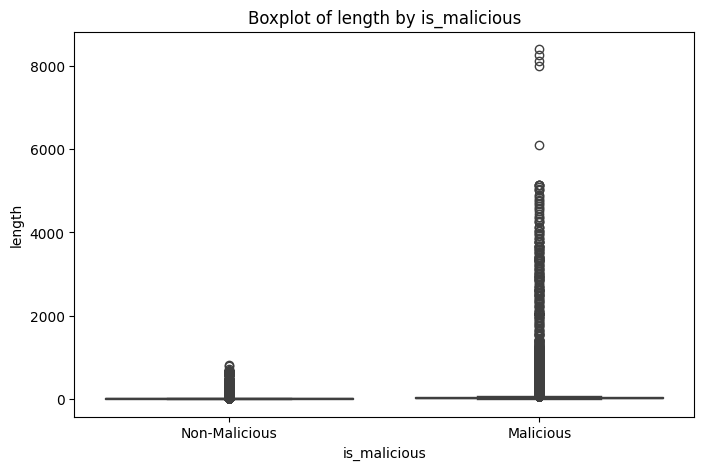

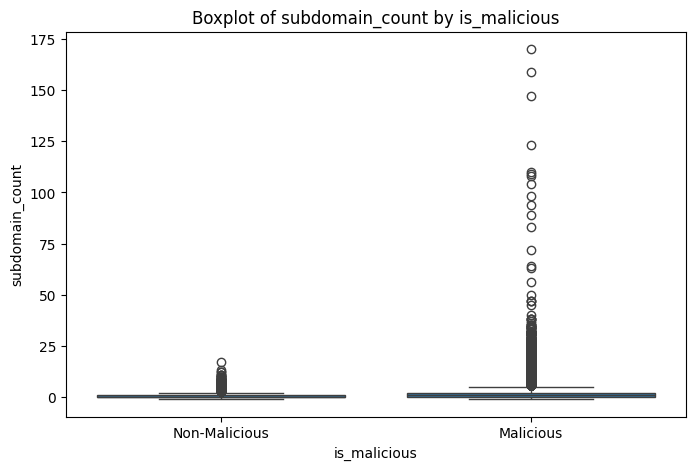

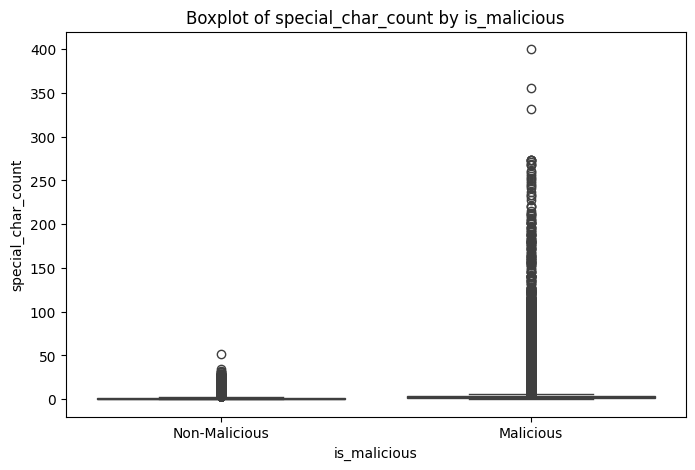

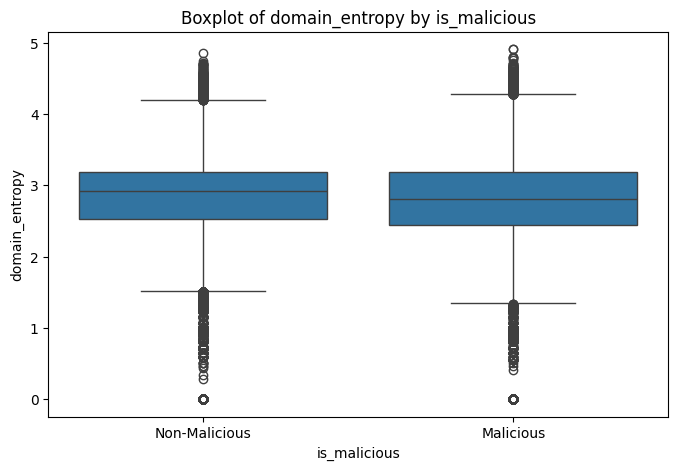

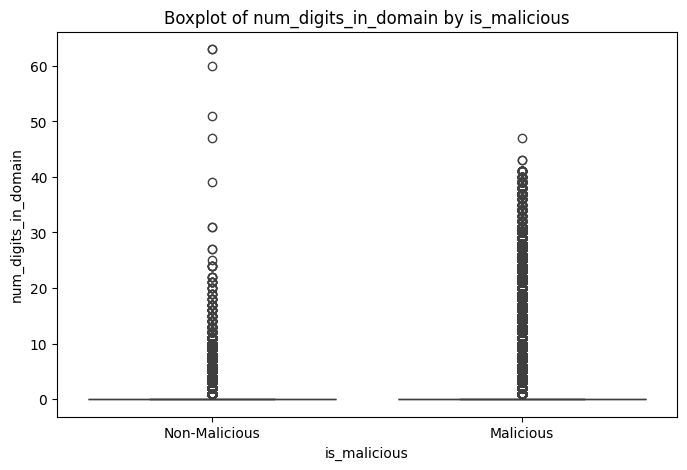

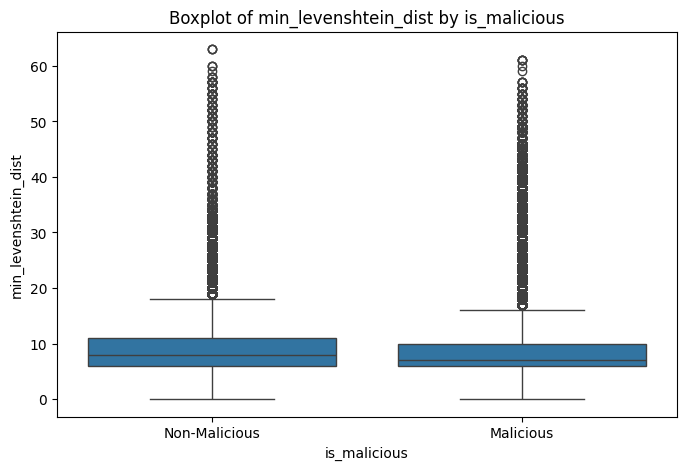

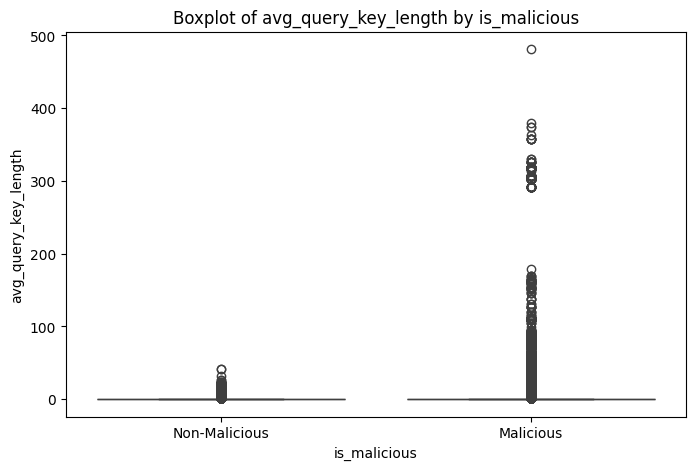

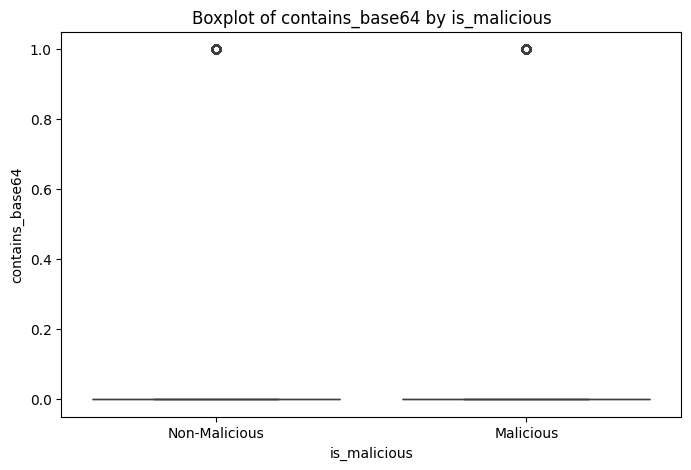

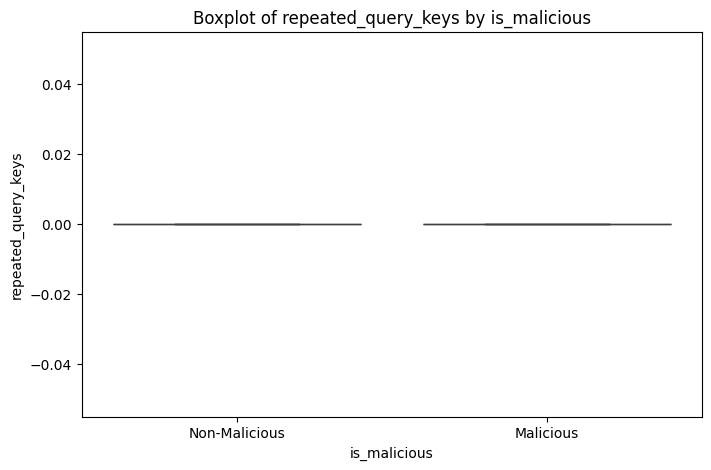

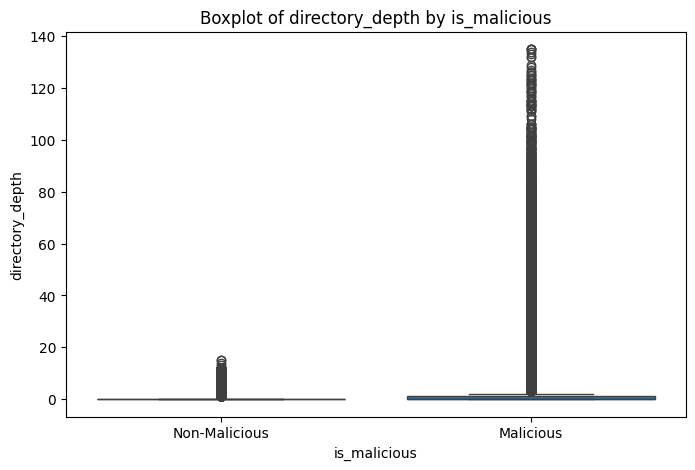

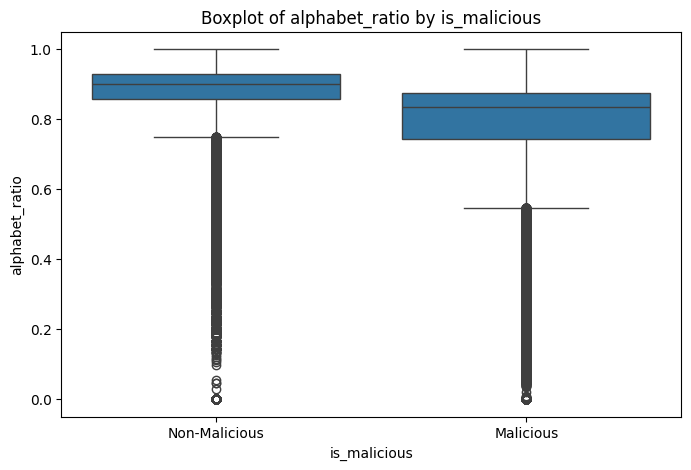

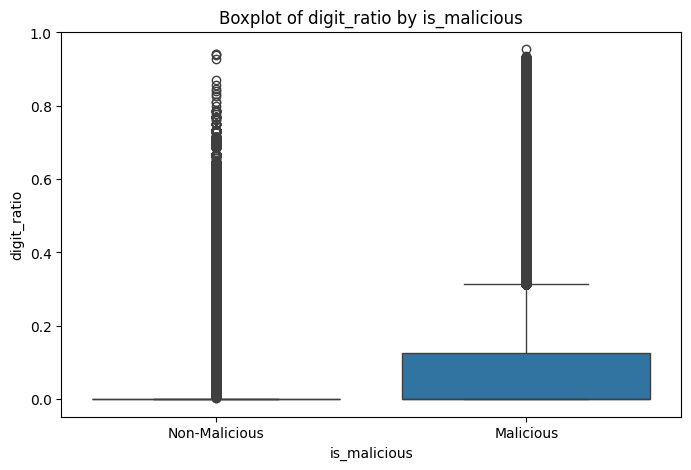

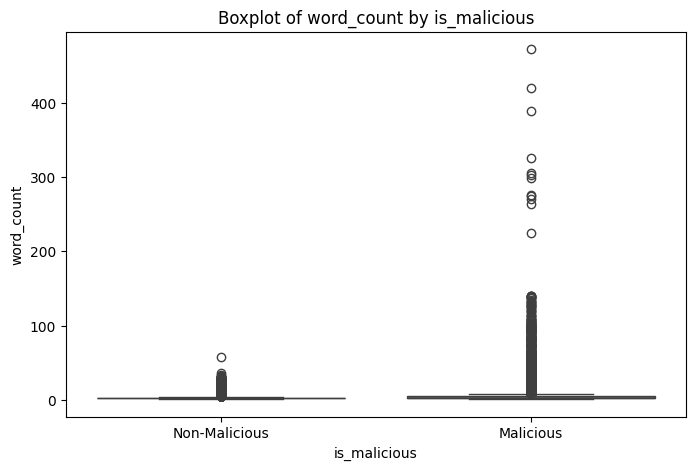

In [ ]:
## ÏïÖÏÑ± Ïó¨Î∂ÄÏóê Îî∞Î•∏ Î∂ÑÌè¨ ÌôïÏù∏
# Î≥ÄÏàò Î™©Î°ù
variables = ['length', 'subdomain_count', 'special_char_count', 'domain_entropy', 'num_digits_in_domain', 'min_levenshtein_dist', 'avg_query_key_length', 'contains_base64', 'repeated_query_keys', 'directory_depth', 'alphabet_ratio', 'digit_ratio', 'word_count']

# Î∞ïÏä§ÌîåÎ°Ø
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_df, x='label', y=var)
    plt.title(f"Boxplot of {var} by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(var)
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.show()

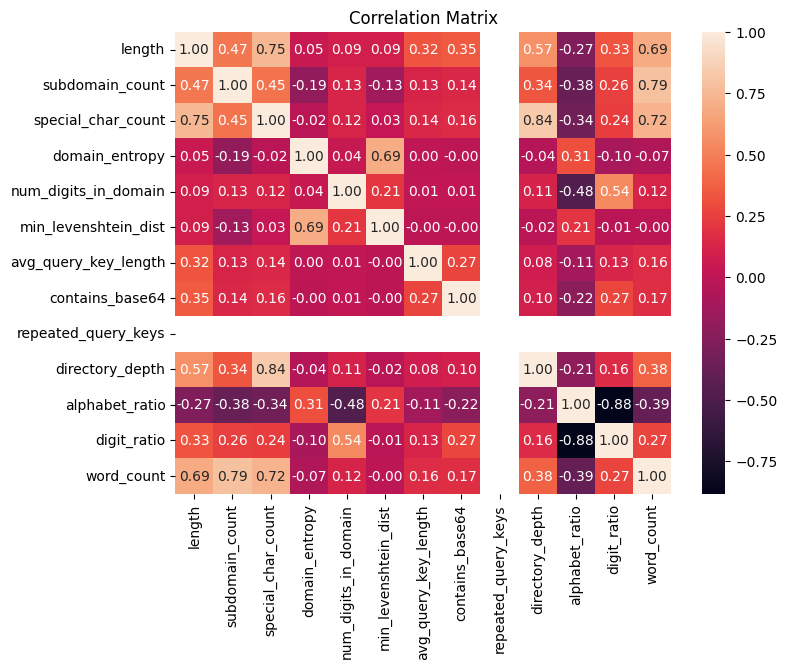

In [ ]:
## ÏÉÅÍ¥ÄÍ≥ÑÏàò Í≥ÑÏÇ∞
# ÏÉÅÍ¥ÄÍ≥ÑÏàò Í≥ÑÏÇ∞
correlation_matrix = train_df[['length', 'subdomain_count', 'special_char_count', 'domain_entropy', 'num_digits_in_domain', 'min_levenshtein_dist', 'avg_query_key_length', 'contains_base64', 'repeated_query_keys', 'directory_depth', 'alphabet_ratio', 'digit_ratio', 'word_count']].corr()

# ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
train_df.head()

ID                                URL  label  length  \
0  TRAIN_0000000                 poznan.wuoz.gov.pl      0      18   
1  TRAIN_0000001                vill.okawa.kochi.jp      0      19   
2  TRAIN_0000002              nationalfinance.co.om      0      21   
3  TRAIN_0000003             town.ozora.hokkaido.jp      0      22   
4  TRAIN_0000004  open24.ie-news.irish/online/Login      1      33   

   subdomain_count  special_char_count  domain_entropy  num_digits_in_domain  \
0                2                   0        2.251629                   0.0   
1                2                   0        1.500000                   0.0   
2                1                   0        2.923231                   0.0   
3                2                   0        2.000000                   0.0   
4                1                   3        2.521641                   0.0   

   min_levenshtein_dist  avg_query_key_length  contains_base64  \
0                   4.0                   0.0            False   
1                   5.0                   0.0            False   
2                  12.0                   0.0            False   
3                   5.0                   0.0            False   
4                   7.0                   0.0            False   

   repeated_query_keys  
0                False  
1                False  
2                False  
3                False  
4                False

In [ ]:
test_df.head()

ID                                    URL  length  \
0  TEST_0000000             niquelarte.blogspot.com.es      26   
1  TEST_0000001              northernmetalproducts.com      25   
2  TEST_0000002                                  ga.de       5   
3  TEST_0000003  florawww.eeb.uconn.edu/199300089.html      37   
4  TEST_0000004                      activecity.moscow      17   

   subdomain_count  special_char_count  domain_entropy  num_digits_in_domain  \
0                2                   0        2.750000                   0.0   
1                0                   0        3.653757                   0.0   
2                0                   0        1.000000                   0.0   
3                3                   1        1.921928                   0.0   
4                0                   0        2.721928                   0.0   

   min_levenshtein_dist  avg_query_key_length  contains_base64  \
0                   6.0                   0.0            False   
1                  17.0                   0.0            False   
2                   5.0                   0.0            False   
3                   5.0                   0.0            False   
4                   8.0                   0.0            False   

   repeated_query_keys  probability  
0                False     0.188883  
1                False     0.063263  
2                False     0.016769  
3                False     0.709068  
4                False     0.055865

# 4. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ 

In [ ]:
# ÌïôÏäµÏùÑ ÏúÑÌïú ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò ÌîºÏ≤òÏôÄ ÎùºÎ≤® Ï§ÄÎπÑ
X = train_df[['length', 'subdomain_count', 'special_char_count', 'domain_entropy', 'num_digits_in_domain', 'min_levenshtein_dist', 'avg_query_key_length', 'contains_base64', 'repeated_query_keys', 'directory_depth', 'alphabet_ratio', 'digit_ratio', 'word_count']]
y = train_df['label']

# Ï∂îÎ°†ÏùÑ ÏúÑÌïú ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞Ïùò ÌîºÏ≤ò Ï§ÄÎπÑ
X_test = test_df[['length', 'subdomain_count', 'special_char_count', 'domain_entropy', 'num_digits_in_domain', 'min_levenshtein_dist', 'avg_query_key_length', 'contains_base64', 'repeated_query_keys', 'directory_depth', 'alphabet_ratio', 'digit_ratio', 'word_count']]

### 4-1. AUTOGLUON

In [4]:
import os

# GPU 1Î≤àÏùÑ ÏÇ¨Ïö©ÌïòÎèÑÎ°ù ÌôòÍ≤Ω Î≥ÄÏàò ÏÑ§Ï†ï
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

predictor = MultiModalPredictor(label='label', problem_type='binary')

In [5]:
# ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò(class weight)Î•º Í≥ÑÏÇ∞ÌïòÍ≥† Ï†ïÍ∑úÌôî -> ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Ìï¥ÏÜå
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label']), y=train_df['label'].values)
weights /= weights.sum()
weights = list(weights)

In [ ]:
predictor.fit(
    train_data=train_df,
    presets='best_quality',
    time_limit=None,
    column_types = {'URL':'text'},
    seed=42,
    hyperparameters={
        "model.hf_text.checkpoint_name": "r3ddkahili/final-complete-malicious-url-model",
        "env.per_gpu_batch_size": 32,
        "optimization.patience": 5,
        "env.num_gpus": 1,
        "optimization.loss_function": "focal_loss",
        "optimization.focal_loss.alpha": weights,
    }
)

In [ ]:
# Ïã§ÌóòÌï† Seed Í∞í Î¶¨Ïä§Ìä∏
seed_values = [16, 17, 21, 42, 11, 20, 47, 100, 123]  # ÏõêÌïòÎäî ÎßåÌÅº Ï∂îÍ∞Ä Í∞ÄÎä•

# ÏÑ±Îä• Í≤∞Í≥º Ï†ÄÏû• Î¶¨Ïä§Ìä∏
results = []

for seed in seed_values:
    print(f"Training with seed = {seed}")

    # Î™®Îç∏ Ï†ÄÏû• Í≤ΩÎ°ú ÏÑ§Ï†ï
    model_path = f"AutogluonModels/seed_{seed}"
    if os.path.exists(model_path):
        os.system(f"rm -rf {model_path}")  # Í∏∞Ï°¥ Î™®Îç∏ ÏÇ≠Ï†ú

    predictor = MultiModalPredictor(
        label='label', 
        problem_type='binary',
        path=model_path  # Î™®Îç∏ÏùÑ Ìï¥Îãπ Í≤ΩÎ°úÏóê Ï†ÄÏû•
    )

    predictor.fit(
        train_data=train_df,
        presets='best_quality',
        time_limit=None,
        column_types={'URL': 'text'},
        seed=seed,
        hyperparameters={
            "model.hf_text.checkpoint_name": "r3ddkahili/final-complete-malicious-url-model",
            "env.per_gpu_batch_size": 32,
            "optimization.patience": 3,
            "env.num_gpus": 1,
            "optimization.loss_function": "focal_loss",
            "optimization.focal_loss.alpha": weights,
        }
    )

    # Ï†ÄÏû•Îêú Î™®Îç∏ÏóêÏÑú ÏµúÏ†ÅÏùò ROC-AUC Ï†êÏàòÎ•º Í∞ÄÏ†∏Ïò¥
    summary = predictor.fit_summary()
    best_roc_auc = summary.get('best_validation_score', None)  # 'best_validation_score'ÏóêÏÑú ÏµúÏ†Å ÏÑ±Îä• ÌôïÏù∏
    
    results.append({"seed": seed, "roc_auc": best_roc_auc})

# Í≤∞Í≥º Ï†ïÎ¶¨
results_df = pd.DataFrame(results)
import ace_tools_open as tools
tools.display_dataframe_to_user(name="SeedÎ≥Ñ ÏµúÏ¢Ö ROC-AUC ÎπÑÍµê", dataframe=results_df)

# ÏµúÏ†Å Seed Í∞í ÏÑ†ÌÉù
valid_results = results_df.dropna(subset=["roc_auc"])  # Ïú†Ìö®Ìïú Í≤∞Í≥ºÎßå Í≥†Î†§
if not valid_results.empty:
    best_seed = valid_results.loc[valid_results["roc_auc"].idxmax(), "seed"]
    print(f"Best seed value based on AutoGluon's final ROC-AUC: {best_seed}")
else:
    print("No valid ROC-AUC results found.")

In [7]:
# Í≤∞Í≥º Ï†ïÎ¶¨
results_df = pd.DataFrame(results)
import ace_tools_open as tools
tools.display_dataframe_to_user(name="SeedÎ≥Ñ ÏµúÏ¢Ö ROC-AUC ÎπÑÍµê", dataframe=results_df)

# ÏµúÏ†Å Seed Í∞í ÏÑ†ÌÉù
valid_results = results_df.dropna(subset=["roc_auc"])  # Ïú†Ìö®Ìïú Í≤∞Í≥ºÎßå Í≥†Î†§
if not valid_results.empty:
    best_seed = valid_results.loc[valid_results["roc_auc"].idxmax(), "seed"]
    print(f"Best seed value based on AutoGluon's final ROC-AUC: {best_seed}")
else:
    print("No valid ROC-AUC results found.")

SeedÎ≥Ñ ÏµúÏ¢Ö ROC-AUC ÎπÑÍµê


No valid ROC-AUC results found.


In [6]:
preds = predictor.predict_proba(
    test_df
)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [7]:
submission_df = pd.read_csv('./data/sample_submission.csv')
submission_df['probability'] = preds[1]
submission_df.to_csv('submission_autogl.csv', index=False)

In [ ]:
# # ÌïôÏäµÎêú Î™®Îç∏ Î°úÎìú (Í∞Å Î™®Îç∏Ïùò Í≤ΩÎ°úÎ•º Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•)
# model_paths = [
#     'AutogluonModels/ag-20250208_152549'
# ]

# # Î™®Îç∏ Í∞ùÏ≤¥ Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
# models = [MultiModalPredictor.load(path) for path in model_paths]
# model = models[0]

Load pretrained checkpoint: c:\Code\Í∞ïÏùòÎÖ∏Ìä∏\ML\ÏïÖÏÑ±URLÎ∂ÑÎ•ò\AutogluonModels\ag-20250208_152549\model.ckpt


# 5. K-fold Î™®Îç∏ ÌïôÏäµ

In [ ]:
# ÎûúÎç§ ÏÑúÏπòÎ•º ÏúÑÌïú ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
param_distributions = {
    'n_estimators': [100, 200, 300],  # Ìä∏Î¶¨ Í∞úÏàò
    'max_depth': [3, 5, 7, 10],       # Ìä∏Î¶¨ ÍπäÏù¥
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # ÌïôÏäµÎ•†
    'subsample': [0.6, 0.8, 1.0],     # ÏÉòÌîåÎßÅ ÎπÑÏú®
    'colsample_bytree': [0.6, 0.8, 1.0],  # Ïª¨Îüº ÏÉòÌîåÎßÅ ÎπÑÏú®
    'gamma': [0, 0.1, 0.2, 0.3],      # Î¶¨ÌîÑ ÎÖ∏Îìú Î∂ÑÌï† ÏµúÏÜå ÏÜêÏã§ Í∞êÏÜåÎüâ
    'reg_alpha': [0, 0.01, 0.1, 1],   # L1 Ï†ïÍ∑úÌôî
    'reg_lambda': [0, 0.01, 0.1, 1],  # L2 Ï†ïÍ∑úÌôî
}

# K-Fold ÏÑ§Ï†ï
kf = KFold(n_splits=4, shuffle=True, random_state=42)
models = []  # Î™®Îç∏ Ï†ÄÏû•
auc_scores = []

# ÎûúÎç§ ÏÑúÏπò Ïã§Ìñâ
print("üîç RandomizedSearchCVÎ•º ÏàòÌñâÌïòÏó¨ ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º Ï∞æÏäµÎãàÎã§...")
lgbm = LGBMClassifier(use_label_encoder=False, eval_metric="auc", random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_distributions,
    n_iter=20,  # ÎûúÎç§ ÏÉòÌîåÎßÅ ÌöüÏàò
    scoring='roc_auc', 
    cv=3,  # ÎÇ¥Î∂Ä ÍµêÏ∞® Í≤ÄÏ¶ù Fold Í∞úÏàò
    verbose=2, 
    n_jobs=-1, 
    random_state=17
)

random_search.fit(X, y)  # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ ÌÉêÏÉâ
best_params = random_search.best_params_
print(f"‚úÖ ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {best_params}")

# K-Fold Î™®Îç∏ ÌïôÏäµ (ÏµúÏ†ÅÏùò ÌååÎùºÎØ∏ÌÑ∞ Ï†ÅÏö©)
for idx, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    print('-'*40)
    print(f'Fold {idx + 1} Î≤àÏß∏ XGBoost Î™®Îç∏ÏùÑ ÌïôÏäµÌï©ÎãàÎã§.')
    print('Epoch|         Train AUC             |         Validation AUC')

    # ÏµúÏ†ÅÏùò ÌååÎùºÎØ∏ÌÑ∞ Ï†ÅÏö©ÌïòÏó¨ Î™®Îç∏ ÏÉùÏÑ±
    model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="auc", random_state=42)
    
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=True,  
    )

    models.append(model)  # Î™®Îç∏ Ï†ÄÏû•

    # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Î∞è ROC-AUC Í≥ÑÏÇ∞
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f"Fold {idx + 1} CV ROC-AUC: {auc:.4f}")
    print('-'*40)
    auc_scores.append(auc)

print(f"K-Fold ÌèâÍ∑† ROC-AUC: {np.mean(auc_scores):.4f}")

üîç RandomizedSearchCVÎ•º ÏàòÌñâÌïòÏó¨ ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º Ï∞æÏäµÎãàÎã§...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
‚úÖ ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}
----------------------------------------
Fold 1 Î≤àÏß∏ XGBoost Î™®Îç∏ÏùÑ ÌïôÏäµÌï©ÎãàÎã§.
Epoch|         Train AUC             |         Validation AUC
[0]	validation_0-auc:0.89203	validation_1-auc:0.89129
[1]	validation_0-auc:0.90424	validation_1-auc:0.90346
[2]	validation_0-auc:0.90723	validation_1-auc:0.90651
[3]	validation_0-auc:0.90793	validation_1-auc:0.90722
[4]	validation_0-auc:0.90671	validation_1-auc:0.90605
[5]	validation_0-auc:0.90963	validation_1-auc:0.90899
[6]	validation_0-auc:0.90920	validation_1-auc:0.90854
[7]	validation_0-auc:0.90876	validation_1-auc:0.90809
[8]	validation_0-auc:0.90893	validation_1-auc:0.90825
[9]	validation_0-au

# 6. K-fold ensemble Î™®Îç∏ ÌïôÏäµ

In [ ]:
# ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞ Ï∂îÎ°†
# Í∞Å Fold Î≥Ñ Î™®Îç∏Ïùò ÏòàÏ∏° ÌôïÎ•† Í≥ÑÏÇ∞
test_probabilities = np.zeros(len(X_test)) 

for model in models:
    test_probabilities += model.predict_proba(X_test)[:, 1]  # ÏïÖÏÑ± URL(1)Ïùº ÌôïÎ•† Ìï©ÏÇ∞

# Soft-Voting ÏïôÏÉÅÎ∏î (Fold Î≥Ñ Î™®Îç∏Îì§Ïùò ÏòàÏ∏° ÌôïÎ•† ÌèâÍ∑†)
test_probabilities /= len(models)
print('Inference Done.')

Inference Done.


# 7. Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±

In [ ]:
# Í≤∞Í≥º Ï†ÄÏû•
test_df['probability'] = test_probabilities
test_df[['ID', 'probability']].to_csv('./submission.csv', index=False)
print('Done.')

Done.


In [ ]:
print(test_df)

                   ID                                    URL  length  \
0        TEST_0000000             niquelarte.blogspot.com.es      26   
1        TEST_0000001              northernmetalproducts.com      25   
2        TEST_0000002                                  ga.de       5   
3        TEST_0000003  florawww.eeb.uconn.edu/199300089.html      37   
4        TEST_0000004                      activecity.moscow      17   
...               ...                                    ...     ...   
1747684  TEST_1747684                     culliganlaredo.com      18   
1747685  TEST_1747685                       tenzidetailer.pl      16   
1747686  TEST_1747686              club-hippique-neubourg.fr      25   
1747687  TEST_1747687                            smbcyt.com/      11   
1747688  TEST_1747688                      schule-am-ried.de      17   

         subdomain_count  special_char_count  domain_entropy  \
0                      2                   0        2.750000   
1      